<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse-2d/blob/master/src/notebook/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est de prédire la position et la hauteur d'un saut de densité (créneau) $\rho$, à partir de $E_l, E_d, E_r, E_u$ (energie des photons), $F_l, F_d, F_r, F_u$ (flux des photons), et $T_l, T_d, T_r, T_u$ (temperature du milieu) sur les bords du domaine en tout temps.

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import keras
import random
import sklearn

from ast import literal_eval as l_eval
from scipy.stats import reciprocal

In [ ]:
from keras import layers
from keras import models
from keras import utils 
from keras import losses
from keras import metrics
from keras import optimizers
from keras import backend as K
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
np.set_printoptions(precision = 3)

In [ ]:
""" DEPUIS GOOGLE DRIVE """
# from google.colab import drive
# drive.mount('/gdrive')

' DEPUIS GOOGLE DRIVE '

In [ ]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/Projet\ inverse/2D/Apprentissage3
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/Projet inverse/2D/Apprentissage3

checkpoint  DRNN_2D_CIR.h5   Labels/            Samples/
Data/       DRNN_2D_CIR.tf/  regression3.ipynb  TestHauteruCrenaux.ipynb


# PREPARATION

## Chargement des données

Les donnees contiennent contiennent $\rho$, $E$, $F$, et $T$. Elles sont sauvegardées dans un format binaire intitulé **SDS** (source-densité-signal). La version 01 de ce format est structurée dans l'ordre ci-après (l'en-tete du fichier est compris entre les lignes horizontales, et le reste represente la structure d'une des simulations presente dans le fichier):

---
- **`5`** octets pour la constante magique **sds01**
- __`2`__ octets pour le nombre de simulations presentes dans le fichier
- __`2`__ octets pour `N` (nombre de mailles en horizontale)
- __`2`__ octets pour `M` (nombre de mailles en verticale)
- __`2`__ octets pour `step_count` (nombre d'iterations en temps)
- **`1`** octet pour le charactere 0xA (newline)
---
- **`1`** octet pour le bord sur lequel se trouve la source: (0 pour up, 1 pour down, 2 pour left, 3 pour right, et -1 si aucun de ces 4)
- **`1`** octet pour la position de la source sur son bord: (0 pour (0.1, 0.3), 1 pour (0.3, 0.5), 2 pour (0.5, 0.7), 3 pour (0.7, 0.9), et -1 si aucun de ces 4)
- __`4 * 4`__ octets pour les attributs du crenau de densite: 4 octets (float) pour l'abcisse, 4 pour l'ordonee, 4 pour la valeur de la densite en dehors du crenau, et 4 pour la  hauteur du crenau.
- **`step_count * N * 4`** octets pour E_up
- idem pour F_up
- idem pour T_up
- **`step_count * N * 4`** octets pour E_down
- idem pour F_up
- idem pour T_up
- **`step_count * M * 4`** octets pour E_left
- idem pour F_left
- idem pour T_left
- **`step_count * M * 4`** octets pour E_right
- idem pour F_right
- idem pour T_right
- **`1`** octet pour le charactere 0xA (newline)

In [ ]:
""" Fonction pour lire le format binaire SDS """
def read_sds_version01(file_path):

  file = open(file_path, "rb")

  sds_version = file.read(5)
  assert(sds_version == b'sds01')

  simu_count = int.from_bytes(file.read(2), byteorder='little', signed=False)
  N = int.from_bytes(file.read(2), byteorder='little', signed=False)
  M = int.from_bytes(file.read(2), byteorder='little', signed=False)
  step_count = int.from_bytes(file.read(2), byteorder='little', signed=False)

  assert(file.read(1) == b'\n')

  X = np.zeros(shape=(simu_count // 4, step_count, N, 4, 4, 3), dtype=np.float32)
  y = np.zeros(shape=(simu_count // 4, 4), dtype=np.float32)

  index = 0
  pos_count = 0
  while True:
    next_byte = file.read(1)
    if next_byte == b'':
      break

    source_edge = int.from_bytes(next_byte, byteorder='little', signed=True)
    source_pos = int.from_bytes(file.read(1), byteorder='little', signed=True)
    assert (source_edge != -1 and source_pos != -1)
    # print("index", index)
    # print("source ", source_edge, source_pos)

    rho_attr = file.read(4*4)
    y[index, :] = np.frombuffer(rho_attr, dtype=np.float32)

    for e in range(4):
      for ch in range(3):
        signal = file.read(step_count*N*4)
        X[index, :, :, e, source_pos, ch] = np.frombuffer(signal, dtype=np.float32).reshape(step_count, N)

    assert(file.read(1) == b'\n')
    pos_count += 1
    if pos_count == 4:
      index += 1
      pos_count = 0

  return X, y

La hauteur du crenau (avant lissage) varie d'une partie a l'autre. Les grille de positions x et y varie aussi mais on a toujours un mailalge de taille 20x20 pour chaque partie (1600 simulations). 

- **PART 1**: La hauteur du crenau (avant lissage) vaut 16 et sur le maillage `[0.2, ..., 0.8] x [0.2, ..., 0.8]`  
- **PART 2**: La hauteur du crenau (avant lissage) vaut 14 et sur le maillage `[0.2, ..., 0.8] x [0.25, ..., 0.75]`  
- **PART 3**: La hauteur du crenau (avant lissage) vaut 12 et sur le maillage `[0.2, ..., 0.8] x [0.3, ..., 0.7]`  
- **PART 4**: La hauteur du crenau (avant lissage) vaut 10 et sur le maillage `[0.25, ..., 0.75] x [0.2, ..., 0.8]`  
- **PART 5**: La hauteur du crenau (avant lissage) vaut 8 et sur le maillage `[0.25, ..., 0.75] x [0.25, ..., 0.75]`  
- **PART 6**: La hauteur du crenau (avant lissage) vaut 6 et sur le maillage `[0.25, ..., 0.75] x [0.3, ..., 0.7]`  
- **PART 7**: La hauteur du crenau (avant lissage) vaut 4 et sur le maillage `[0.3, ..., 0.7] x [0.2, ..., 0.8]`  
- **PART 8**: La hauteur du crenau (avant lissage) vaut 2 et sur le maillage `[0.3, ..., 0.7] x [0.25, ..., 0.75]`  
- **PART 9**: La hauteur du crenau (avant lissage) vaut 1 et sur le maillage `[0.3, ..., 0.7] x [0.3, ..., 0.7]`  
- **PART 10**: La hauteur du crenau (avant lissage) vaut 1 et sur le maillage `[0.2, ..., 0.8] x [0.2, ..., 0.8]`  

- **PART 11**: La hauteur du crenau (avant lissage) vaut 0.1 et sur le maillage `[0.2, ..., 0.8] x [0.2, ..., 0.8]` (mais seulement sur un nombre limite de positions)




On a aut total 10 parties contenant 400 positions chacunes. Aussi, chaque simulation a necessite 168 iterations sur un maillage de 28 x 28.  On peut donc creer $X$ sous la forme `(10, 400, 168, 28, 4, 4, 3)`.
- le premier 4 represente le nombre de bords du domaine
- le deuxieme 4 represente le nombre de sources differentes sur le bord gauche
- le 3 represente le nombre de canaux ($E$, $F$ et $T$).

On cree $y$ sous la forme `(10, 400, 4)`. Le 4 represente le nombre d'attributs du crenau sur la densite. Seuls l'abcisse et l'ordonee du crenau nous intéressent (1er et 2e attributs).

In [ ]:
n_parts = 10
n_pos = 400
step_count = 168
N = 28 # N=M
n_edges = 4
n_sources = 4
n_channels = 3

n_attr = 4

X = np.zeros(shape=(n_parts, n_pos, step_count, N, n_edges, n_sources, n_channels), dtype=np.float32)
y = np.zeros(shape=(n_parts, n_pos, n_attr), dtype=np.float32)

for i in range(n_parts):
  X[i], y[i] = read_sds_version01("part"+str(i+1)+".sds")

print("Les dimensions preliminaires:\n")
print("X shape:", X.shape)
print("y shape:", y.shape)

KeyboardInterrupt: ignored

De facon alternative, on peut charger les donnees qui ont ete sauvegardees avec Numpy.

In [ ]:
# """ Lecture avec Numpy """

## Separation des données

Avant de separer en train, val et test, il faut normaliser et reshape X. Il faut aussi rendomiser X et y.

In [ ]:
""" Une fonction pour detecter le min et le max d'un tenseur en excluant les NaN """
def min_max(mat, dim=2):
  mat_min = mat
  for i in range(dim-1, -1, -1):
      mat_min = np.nanmin(mat_min, axis=i)
      
  mat_max = mat
  for i in range(dim-1, -1, -1):
      mat_max = np.nanmax(mat_max, axis=i)

  return mat_min, mat_max

""" On fait une simple normalisation des donnnees. Division par le maximum de valeur absolue de sur chaque canal de X """
min_E, max_E = min_max(np.abs(X[:, :, :, :, :, :, 0]), 3)
min_F, max_F = min_max(np.abs(X[:, :, :, :, :, :, 1]), 3)
min_T, max_T = min_max(np.abs(X[:, :, :, :, :, :, 2]), 3)

X[:, :, :, :, :, :, 0] = X[:, :, :, :, :, :, 0] / max_E
X[:, :, :, :, :, :, 1] = X[:, :, :, :, :, :, 1] / max_F
X[:, :, :, :, :, :, 2] = X[:, :, :, :, :, :, 2] / max_T

In [ ]:
""" On reshape X sous la forme (n_pos_total, step_count, N, 4*4*3) """
X = X.reshape((n_parts, n_pos, step_count, N, n_edges * n_sources * n_channels))

X = X.reshape((-1, step_count, N, n_edges * n_sources * n_channels))

In [ ]:
n_samples = len(X)
print("X shape =", X.shape)

In [ ]:
""" verifier qu'aucun des X n'est completement vide (null)  """
for i in range(n_samples):
  assert np.all(X[i] == 0) == False

In [ ]:
""" On reshape y et on extrait juste ses deux premieres colones """
y = y.reshape((-1, n_attr))
y = y[:, [0, 1, 3]]

In [ ]:
n_targets = len(y)
print("y shape =", y.shape)

In [ ]:
""" On fait une permutation des entrees et sorties """
shuffle = np.arange(n_samples)
random.shuffle(shuffle)

X_copy = X.copy()
y_copy = y.copy()

for i in range(n_samples):
  X_copy[i] = X[shuffle[i]]
  y_copy[i] = y[shuffle[i]]

X = X_copy
y = y_copy

del X_copy
del y_copy

In [ ]:
len_train, len_val = 7*len(X)//10, 2*len(X)//10

X_train = X[:len_train]
X_val = X[len_train:len_train+len_val]
X_test = X[len_train+len_val:]

y_train = y[:len_train]
y_val = y[len_train:len_train+len_val]
y_test = y[len_train+len_val:]

print("X shapes =", np.shape(X_train), np.shape(X_val), np.shape(X_test))
print("y shapes =", np.shape(y_train), np.shape(y_val), np.shape(y_test))

In [ ]:
# """ Sauvegarde de ce jeu de donnees pour un prochain apprentissage """
# np.save("../Samples/train", X_train)
# np.save("../Samples/val", X_val)
# np.save("../Samples/test", X_test)

## Chargement au format Numpy

In [ ]:
""" Les constantes """
n_parts = 10
n_pos = 400
step_count = 168
N = 28 # N=M
n_edges = 4
n_sources = 4
n_channels = 3

n_attr = 4

In [ ]:
""" Chargement des donnnees """

X_train = np.load("Samples/train.npy")
X_val = np.load("Samples/val.npy")
X_test = np.load("Samples/test.npy")

y_train = np.load("Labels/train.npy")
y_val = np.load("Labels/val.npy")
y_test = np.load("Labels/test.npy")

In [ ]:
print("Les dimensions des donnees:\n")
print("X shapes:", X_train.shape, X_val.shape, X_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)

Les dimensions des donnees:

X shapes: (2800, 168, 28, 48) (800, 168, 28, 48) (400, 168, 28, 48)
y shapes: (2800, 3) (800, 3) (400, 3)


# APPRENTISSAGE

## Configuration du modèle 

In [ ]:
""" Un modèle convolutif """
model = models.Sequential(name="Convoluted_DRNN")

kernel_size = (6, 2)
strides = (1, 1)

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu', input_shape=(step_count, N, n_edges * n_sources * n_channels)))
model.add(layers.Conv2D(32, kernel_size, strides=strides, activation='relu'))

# model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))

# model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(3, activation='linear'))

model.summary()

Model: "Convoluted_DRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 163, 27, 64)       36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 158, 26, 32)       24608     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 153, 25, 64)       24640     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 24, 64)       49216     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 143, 23, 128)      98432     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 138, 22, 128)      196736    
_________________________________________________________________
flatten_2 (Flatten)          (None, 388608)        

Pour la compilation:
- on utlise l'optimiseur Adam
- on utlise la `mse` pour fonction loss
- on observe le coefficient de determination

In [ ]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=-1) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=keras.losses.mse,
              # metrics=[keras.metrics.mean_absolute_error]
              # metrics=[keras.metrics.MeanAbsolutePercentageError(name="accuracy", dtype=None)]
              # metrics=[keras.metrics.CosineSimilarity(name="accuracy", dtype=None, axis=-1)]
              metrics=[r2_score]
              )

In [ ]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
  if epoch == 0:
    return 0.001
  else:
    return 0.8 * lr

lr_decrease = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor="r2_score", mode="max", restore_best_weights=True)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/50
88/88 [==============================] - 12s 132ms/step - loss: 3.4988 - r2_score: -0.0465 - val_loss: 3.1037 - val_r2_score: 0.0217
Epoch 2/50
88/88 [==============================] - 12s 132ms/step - loss: 2.5905 - r2_score: 0.2696 - val_loss: 2.1116 - val_r2_score: 0.5530
Epoch 3/50
88/88 [==============================] - 12s 131ms/step - loss: 1.7884 - r2_score: 0.5760 - val_loss: 1.8413 - val_r2_score: 0.8267
Epoch 4/50
88/88 [==============================] - 11s 131ms/step - loss: 1.4042 - r2_score: 0.6907 - val_loss: 1.4166 - val_r2_score: 0.8657
Epoch 5/50
88/88 [==============================] - 11s 129ms/step - loss: 0.9902 - r2_score: 0.8137 - val_loss: 0.9492 - val_r2_score: 0.8926
Epoch 6/50
88/88 [==============================] - 11s 130ms/step - loss: 0.8708 - r2_score: 0.8316 - val_loss: 1.0601 - val_r2_score: 0.9224
Epoch 7/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6571 - r2_score: 0.8793 - val_loss: 0.7644 - val_r2_score: 0.766

In [ ]:
# """ Technique d'augmentation du batch size """
# def fit_increase(batch_sizes):
#   for i, bs in enumerate(batch_sizes):
#     print("STEP "+str(i+1), "/ 4", "- BATCH SIZE =", bs)
#     global history
#     history = model.fit(X_train,
#                         y_train,
#                         # epochs=int(4*(i+1)),
#                         epochs=50,
#                         batch_size=bs,
#                         verbose=1,
#                         callbacks=[early_stopping],
#                         validation_data=(X_val, y_val))
#     print()

# bbs = len(X_train) // 100  # base batch size
# # fit_increase([bbs*1, bbs*5, bbs*10, bbs*20])
# fit_increase([32, 1024])

In [ ]:
# """ Autre facons de modifier le batch size """
# dataSlices = [(0,28),(28,168),(168,448),(448,1008),(1008,2800)]

# for epochs in range(0,10):
#     # shuffle(dataSlices)
#     for i in dataSlices:
#         X_batch, y_batch = X[i[0]:i[1],:],y[i[0]:i[1],:]
#         model.train_on_batch(X_batch, y_batch)

# # def data_gen(X, y):
# #   dataSlices = [(0,28),(28,168),(168,448),(448,1008),(1008,2800)]
  
# #   while True:
# #     shuffle(dataSlices)
# #     i = dataSlices[0]
# #     X_batch, y_batch = X[i[0]:i[1],:],y[i[0]:i[1],:]

# #     yield X_batch, y_batch

# # history = model.fit(data_gen(X_train, y_train), 
# #                     steps_per_epoch=100, 
# #                     epochs=100,
# #                     verbose=1,
# #                     callbacks=[early_stopping],
# #                     validation_data=(X_val, y_val))

Verifions le taux d'apprentissage final.

In [ ]:
print("final learning rate:", round(model.optimizer.lr.numpy(), 5))

final learning rate: 1e-05


Observons la decroissance de la loss

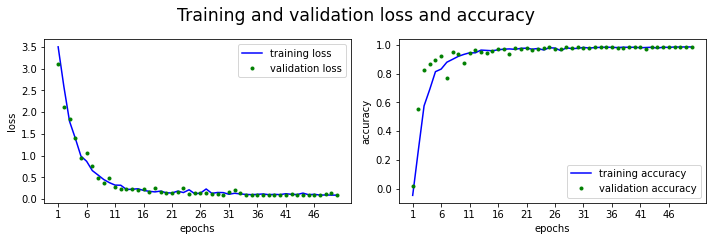

In [ ]:
history_dict = history.history

loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
acc = history_dict['r2_score']
val_acc = history_dict['val_r2_score']

epochs = range(1, len(loss)+1)
ticks = range(1, len(loss)+1, 5)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')
ax0.set_xticks(ticks)
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
# ax0.set_ylim(0, 1)
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xticks(ticks)
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
# ax1.set_ylim(-1, 1)
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

In [ ]:
# """ Sauvegardons les bons modeles qu'on obtient """
# model.save('DRNN_2D_CIR.h5')

In [ ]:
# # """ Chargeons le modele """
# model = keras.models.load_model("DRNN_2D_CIR.h5", custom_objects={"r2_score": r2_score}, compile=False)
# model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.mse, metrics=[r2_score])

## Quelques predictions

In [ ]:
hat_y_test = model.predict(X_test)

In [ ]:
def print_prediction(hat_y_test, nb):
  len_test = len(X_test)
  for i in range(0, len_test, len_test//nb):
    print("target:    ", y_test[i])
    print("prediction:", hat_y_test[i], "\n")

print_prediction(hat_y_test, 20)

target:     [0.263 0.25  8.44 ]
prediction: [0.209 0.262 8.23 ] 

target:     [0.468 0.579 2.128]
prediction: [0.461 0.587 2.092] 

target:     [0.355 0.645 3.576]
prediction: [0.359 0.667 3.016] 

target:     [0.35  0.65  7.732]
prediction: [0.297 0.673 7.869] 

target:     [0.574 0.405 0.64 ]
prediction: [0.538 0.432 0.636] 

target:     [0.645 0.329 4.208]
prediction: [0.653 0.301 4.328] 

target:     [0.75  0.645 3.576]
prediction: [0.687 0.65  3.073] 

target:     [0.592 0.618 5.472]
prediction: [0.583 0.619 6.351] 

target:     [0.468 0.389 1.816]
prediction: [0.447 0.385 1.56 ] 

target:     [0.2   0.461 9.552]
prediction: [0.108 0.504 9.401] 

target:     [0.592 0.642 6.04 ]
prediction: [0.575 0.65  6.024] 

target:     [0.321 0.616 0.64 ]
prediction: [0.442 0.563 0.578] 

target:     [0.405 0.539 1.24 ]
prediction: [0.419 0.522 1.188] 

target:     [0.637 0.705 2.44 ]
prediction: [0.62  0.712 2.595] 

target:     [0.697 0.276 5.472]
prediction: [0.711 0.262 6.366] 

target:   

In [ ]:
""" Le score r2 d'apres Keras """

print("r2 score on predictions: %.2f"%(100*model.evaluate(X_test, y_test)[1]), "%")

13/13 [==============================] - 0s 29ms/step - loss: 0.0923 - r2_score: 0.9856
r2 score on predictions: 98.56 %


Deffinissons une mesure d'accuracy. 

On suppose la prediction correcte si elle est suffisament proche du label:
- au **dizième** près pour la position (suivant x ou y)
- à l'**unité** près pour la hauteur 

In [ ]:
""" Calculons l'accuracy """

condition1 = (abs(y_test[:, 0] - hat_y_test[:, 0]) <= .1)         # postition x
condition2 = (abs(y_test[:, 1] - hat_y_test[:, 1]) <= .1)         # postition y
condition3 = (abs(y_test[:, 2] - hat_y_test[:, 2]) <= 1)          # hauteur

acc_pos_x = 100 * len(hat_y_test[condition1]) / len(hat_y_test)
acc_pos_y = 100 * len(hat_y_test[condition2]) / len(hat_y_test)
acc_hgt = 100 * len(hat_y_test[condition3]) / len(hat_y_test)
acc = 100 * len(hat_y_test[condition1 & condition2 & condition3]) / len(hat_y_test)

print("position x accuracy: %.2f"%acc_pos_x, "%")
print("position y accuracy: %.2f"%acc_pos_y, "%")
print("height accuracy:     %.2f"%acc_hgt, "%")
print()
print("total (hard) accuracy:      %.2f"%acc, "%")

position x accuracy: 93.75 %
position y accuracy: 99.00 %
height accuracy:     93.25 %

total (hard) accuracy:      87.50 %


## Les pires predictions

In [ ]:
def norm(vec):
  return np.sqrt(vec[0]**2 + vec[1]**2 + (vec[2] / 10)**2)

def norm2(vec):
  return np.sqrt(vec[0]**2 + vec[1]**2)

def print_worst(norm):
  worst = [norm(y_test[i] - hat_y_test[i]) for i in range(len(X_test))]
  worst_index = np.flip(np.argsort(worst))

  print(worst_index[:5])
  print()
  for i in worst_index[:5]:
    print("label", y_test[i], "    prediction", hat_y_test[i])

""" On tient compte de tout """
print_worst(norm)

[215  98 115  89  19]

label [0.2  0.65 0.1 ]     prediction [0.579 0.515 0.189]
label [0.2   0.2   0.736]     prediction [0.448 0.317 0.411]
label [0.321 0.7   0.64 ]     prediction [0.459 0.592 0.592]
label [0.2  0.2  3.28]     prediction [0.369 0.188 2.855]
label [0.358 0.642 7.096]     prediction [0.317 0.65  5.497]


In [ ]:
""" On tient compte uniquement de la position """
print_worst(norm2)

[215  98 115  89 278]

label [0.2  0.65 0.1 ]     prediction [0.579 0.515 0.189]
label [0.2   0.2   0.736]     prediction [0.448 0.317 0.411]
label [0.321 0.7   0.64 ]     prediction [0.459 0.592 0.592]
label [0.2  0.2  3.28]     prediction [0.369 0.188 2.855]
label [0.5   0.8   0.736]     prediction [0.533 0.64  0.688]


## Les meilleures predictions

In [ ]:
def print_best(norm):
  best = [norm(y_test[i] - hat_y_test[i]) for i in range(len(X_test))]
  best_index = np.argsort(best)

  print(best_index[:5])
  print()
  for i in best_index[:5]:
    print("label", y_test[i], "    prediction", hat_y_test[i])

In [ ]:
""" On tient compte de tout """
print_best(norm)

[243 261 370 361 218]

label [0.461 0.566 4.208]     prediction [0.455 0.565 4.198]
label [0.461 0.434 4.208]     prediction [0.454 0.433 4.256]
label [0.618 0.642 6.04 ]     prediction [0.614 0.651 6.059]
label [0.487 0.75  4.84 ]     prediction [0.479 0.744 4.873]
label [0.658 0.2   2.44 ]     prediction [0.651 0.192 2.462]


In [ ]:
""" On tient compte uniquement de la position """
print_best(norm2)

[ 92  54 172  63 234]

label [0.513 0.276 5.472]     prediction [0.513 0.278 6.363]
label [0.566 0.434 4.84 ]     prediction [0.564 0.435 5.202]
label [0.539 0.705 6.04 ]     prediction [0.542 0.704 6.6  ]
label [0.487 0.516 6.832]     prediction [0.486 0.519 7.648]
label [0.461 0.539 3.576]     prediction [0.459 0.535 2.994]


## Illustration des correlations

In [ ]:
import seaborn as sb

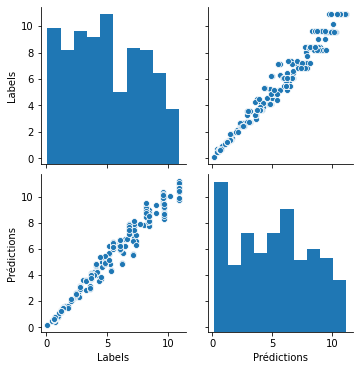

In [ ]:
""" La hauteur du crenau """
df = pd.DataFrame({"Labels":y_test[:, 2]})
df["Prédictions"] = hat_y_test[:, 2]

sb.pairplot(df)

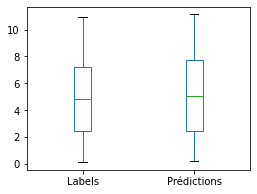

In [ ]:
""" La hauteur du crenau """
ax = df.boxplot(column=["Labels", "Prédictions"], return_type='axes', figsize=(4,3), grid=False)